In [ ]:
# Import resources
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import time
import json
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
from PIL import Image
from collections import OrderedDict
import torch
from torch import nn, optim, cuda
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import os
from glob import glob
import shutil

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#modify hyperparameters
model_type = 'mnas'
act = 'relu' #no capitals
opt = 'sgd' #no capitals
dropout = 0.2
batch_size = 32
#data_type = 'HH'

num_classes = 7
iteration = 0

#download model
if model_type == 'resnet':
  m = models.resnet152(pretrained=True) 
  model = models.resnet152(pretrained=True)
  num_in_features = model.fc.in_features  
if model_type == 'vgg':
  m = models.vgg19(pretrained=True) 
  model = models.vgg19(pretrained=True) 
  num_in_features = 25088 
if model_type == 'densenet':
  m = models.densenet161(pretrained=True) 
  model = models.densenet161(pretrained=True)
  num_in_features = 2208 
if model_type == 'google':
  m = models.googlenet(pretrained = True)
  model = models.googlenet(pretrained = True)
  num_in_features = model.fc.in_features  
if model_type == 'alex':
  m = models.alexnet(pretrained=True)
  model = models.alexnet(pretrained=True)
  num_in_features = 9216
if model_type == 'shuffle':
  m = models.shufflenet_v2_x1_0(pretrained=True)
  model = models.shufflenet_v2_x1_0(pretrained=True)
  num_in_features = model.fc.in_features
if model_type == 'mobile':
  m =models.mobilenet_v2(pretrained=True)
  model = models.mobilenet_v2(pretrained=True)
  num_in_features = 1280
if model_type == 'mnas':
  m =  models.mnasnet1_0(pretrained=True)
  model = models.mnasnet1_0(pretrained=True)
  num_in_features = 1280



#get data directory
data_dir  = "/content/drive/My Drive/Lake detection/greenland/training_data"

#get existing models
model_dir = "/content/drive/My Drive/Lake detection/models"
existing_models = glob(model_dir + '/*.pth')
existing_models2 = list()
for x in existing_models:
  existing_models2.append(x.split('/')[-1])
print(existing_models2)

#check if model name already exists, updata name
model_name = model_type + '_real.pth'
# while model_name in existing_models2:
#   iteration += 1
#   model_name = model_type + '_' + str(iteration) + '.pth'

print(model_name)

Downloading: "https://download.pytorch.org/models/mnasnet1.0_top1_73.512-f206786ef8.pth" to /root/.cache/torch/hub/checkpoints/mnasnet1.0_top1_73.512-f206786ef8.pth



['resnet_0.pth', 'resnet_0_params.pth', 'vgg_0.pth', 'vgg_0_params.pth', 'densenet_0.pth', 'densenet_0_params.pth', 'google_0.pth', 'google_0_params.pth', 'alex_0.pth', 'alex_0_params.pth', 'shuffle_0.pth', 'shuffle_0_params.pth', 'mobile_0.pth', 'mobile_0_params.pth', 'mnas_0.pth', 'mnas_0_params.pth', 'alex_1.pth', 'alex_1_params.pth', 'alex_2.pth', 'alex_2_params.pth', 'alex_3.pth', 'alex_3_params.pth', 'alex_4.pth', 'alex_4_params.pth', 'alex_5.pth', 'alex_5_params.pth', 'alex_6.pth', 'alex_6_params.pth', 'alex_7.pth', 'alex_7_params.pth', 'resnet_1.pth', 'resnet_1_params.pth', 'vgg_1.pth', 'vgg_1_params.pth', 'densenet_1.pth', 'densenet_1_params.pth', 'google_1.pth', 'google_1_params.pth', 'shuffle_1.pth', 'shuffle_1_params.pth', 'mobile_1.pth', 'mobile_1_params.pth', 'mnas_1.pth', 'mnas_1_params.pth', 'alex_8.pth', 'alex_8_params.pth', 'alex_9.pth', 'alex_9_params.pth', 'vgg_real.pth', 'vgg_real_params.pth', 'alex_real_params.pth', 'alex_real.pth', 'resnet_real.pth', 'resnet_rea

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}
# TODO: Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
print(dataset_sizes)

{'train': 4012, 'valid': 888}


In [ ]:
#Set up fully connected layers for Resnet model:
if model_type == 'resnet' or model_type == 'google' or model_type == 'shuffle':
  for param in model.parameters():
      param.requires_grad = False

  if act == 'relu':    
    model.fc = nn.Sequential(nn.Linear(num_in_features, 512),
                                  nn.ReLU(),
                                  nn.Dropout(dropout),
                                  nn.Linear(512, num_classes),
                                  nn.LogSoftmax(dim=1))
  if act == 'sigmoid':    
    model.fc = nn.Sequential(nn.Linear(num_in_features, 512),
                                  nn.Sigmoid(),
                                  nn.Dropout(dropout),
                                  nn.Linear(512, num_classes),
                                  nn.LogSoftmax(dim=1))
  if act == 'tanh':    
    model.fc = nn.Sequential(nn.Linear(num_in_features, 512),
                                  nn.Tanh(),
                                  nn.Dropout(dropout),
                                  nn.Linear(512, num_classes),
                                  nn.LogSoftmax(dim=1))

#set up fully connected layers for vgg and densenet:
elif model_type == 'vgg' or model_type == 'densenet' or model_type == 'alex' or model_type == 'mobile' or model_type == 'mnas':
    for param in model.parameters():
      param.requires_grad = False
    
    classifier = nn.Sequential()
    classifier.add_module('fc0', nn.Linear(num_in_features, 512))
    if act == 'relu':
      classifier.add_module('relu0', nn.ReLU())
    if act == 'sigmoid':
      classifier.add_module('sigmoid0', nn.Sigmoid())
    if act == 'tanh':
      classifier.add_module('tanh0', nn.Tanh())
    classifier.add_module('drop0', nn.Dropout(dropout))
    classifier.add_module('fc1', nn.Linear(512,num_classes))
    classifier.add_module('out', nn.LogSoftmax(dim=1))

    model.classifier = classifier

#other model hyperparameters
criterion = nn.NLLLoss()
if opt == 'sgd':
  optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
if opt == 'adam':
  optimizer = optim.Adam(model.parameters())
if opt == 'adadelta':
  optimizer = optim.Adadelta(model.parameters())
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model.to(device);

In [ ]:
cuda.empty_cache()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    val_accs = list()
    val_losses = list()
    train_accs = list()
    train_losses = list()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid':
                val_accs.append(epoch_acc)
                val_losses.append(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                train_accs.append(epoch_acc)
                train_losses.append(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_accs, train_losses, val_accs, val_losses, time_elapsed

In [ ]:
model, train_accs, train_losses, val_accs, val_losses, time_elapsed = train_model(model, criterion, optimizer, scheduler, num_epochs=20)

Epoch 0/19
----------
train loss: 1.1906 Acc: 0.6062
valid loss: 1.3870 Acc: 0.4550

Epoch 1/19
----------
train loss: 0.6499 Acc: 0.7759
valid loss: 1.2037 Acc: 0.5394

Epoch 2/19
----------
train loss: 0.5601 Acc: 0.8028
valid loss: 1.3347 Acc: 0.4797

Epoch 3/19
----------
train loss: 0.5216 Acc: 0.8178
valid loss: 1.2528 Acc: 0.5113

Epoch 4/19
----------
train loss: 0.4875 Acc: 0.8285
valid loss: 1.0822 Acc: 0.5867

Epoch 5/19
----------
train loss: 0.4810 Acc: 0.8305
valid loss: 1.0128 Acc: 0.6194

Epoch 6/19
----------
train loss: 0.4620 Acc: 0.8357
valid loss: 1.0986 Acc: 0.5833

Epoch 7/19
----------
train loss: 0.4266 Acc: 0.8529
valid loss: 0.9940 Acc: 0.6363

Epoch 8/19
----------
train loss: 0.4181 Acc: 0.8559
valid loss: 0.9442 Acc: 0.6532

Epoch 9/19
----------
train loss: 0.4133 Acc: 0.8517
valid loss: 0.9299 Acc: 0.6554

Epoch 10/19
----------
train loss: 0.3926 Acc: 0.8614
valid loss: 0.9076 Acc: 0.6622

Epoch 11/19
----------
train loss: 0.4012 Acc: 0.8589
valid loss

In [ ]:
#model = torch.load(model_dir + '/' +model_name)
#
model.eval();

preprocess = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
                                     ])

val_imgs = sorted(glob('/content/drive/My Drive/Lake detection/greenland/training_data/all_valid/*.jpg'))

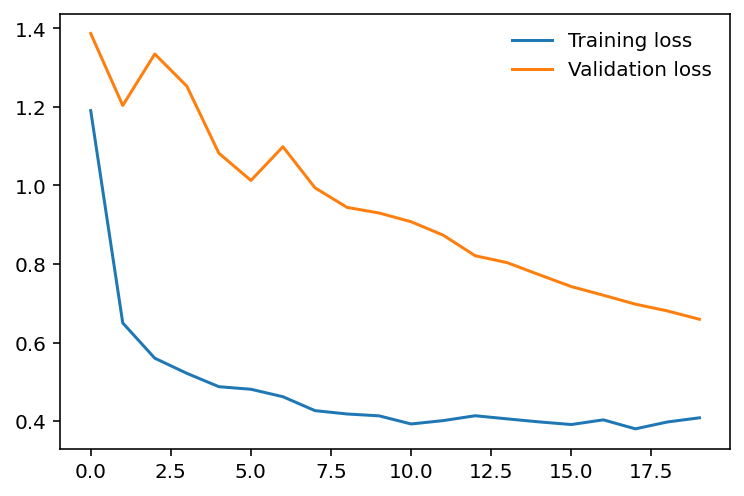

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

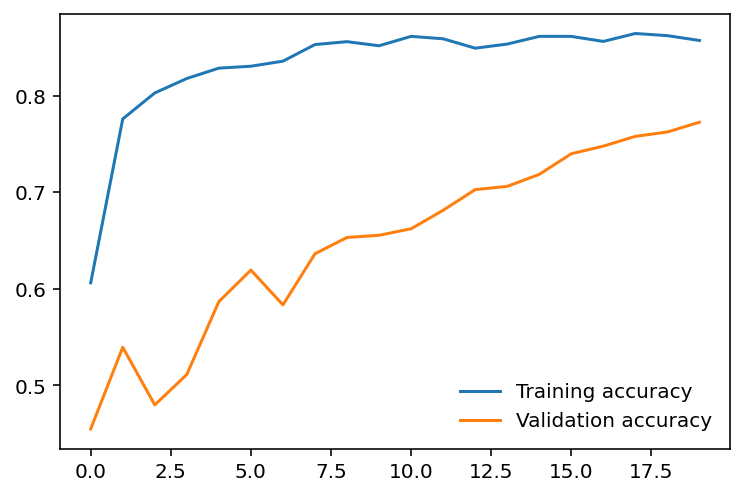

In [ ]:
plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.legend(frameon=False)
plt.show()

In [ ]:
torch.save(model, model_dir + '/' + model_name)


In [ ]:
def get_prediction(probs, th):
    preds = np.asarray(probs.cpu()[0])
    if preds[4] > th:
        predicted = 4
    else:
        preds[4] = 0
        predicted = np.argmax(preds)

    return predicted

In [ ]:
tn = 11
threshold = np.linspace(0,1, tn)
buried_lake_class = 4

TP = np.zeros(tn)
FN = np.zeros(tn) #false negatives
FP = np.zeros(tn) #false positives
TN = np.zeros(tn)
# recall = np.zeros(tn)
# precision = np.zeros(tn)
# #F1 = np.zeros(tn)
# FPR = np.zeros(tn)

for val_img in val_imgs:
    #val_img = val_imgs[i]
    actual = int(val_img.split('/')[-1][-5])
    #print('Actual', actual)
    img = Image.open(val_img)
    # plt.imshow(img) 
    # plt.show()
    img2 = preprocess(img)
    img2 = np.expand_dims(img2, 0) #Convert 2D image to 1D vector
    img2 = torch.from_numpy(img2)

    #classify image
    inputs = Variable(img2).to(device)
    inputs = inputs.float()
    outputs = model(inputs) #labels
    probabilities = torch.softmax(outputs.data, 1) #get probability for each class
    #if actual == 4: print(np.asarray(probabilities.cpu()[0])[4])
    
    for i in range(tn):
        th = threshold[i]
        predicted = get_prediction(probabilities, th)
        #print(f'{th:0.1f}, {predicted}')
        
        if actual == buried_lake_class and predicted == buried_lake_class:
            TP[i] = TP[i] + 1

        elif actual == buried_lake_class and predicted != buried_lake_class:
            FN[i] = FN[i] + 1
          
        elif actual != buried_lake_class and predicted == buried_lake_class:
            FP[i] = FP[i] + 1

        elif actual != buried_lake_class and predicted != buried_lake_class:
            TN[i] = TN[i] + 1


recall = TP / (TP + FN)
precision = TP / (TP + FP)
FPR = (FP)/(TN + FP)
recall[np.isnan(recall)] = 0
precision[np.isnan(precision)] = 0
FPR[np.isnan(FPR)] = 0
F1 = (2*precision*recall)/(precision+recall)
F1[np.isnan(F1)] = 0




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


In [ ]:

params = {'name':model_name,
              'epochs': 20,
              'batch_size': batch_size,
              'model': m,
              'scheduler': scheduler,
              'optimizer': optimizer,
              'train_loss': train_losses,
              'train_acc': train_accs,
              'val_loss': val_losses,
              'val_acc': val_accs,
              'precision': precision,
              'recall': recall,
              'F1': F1,
              'FPR': FPR,
              'time':time_elapsed
}
          
torch.save(params, model_dir + '/' + model_name[:-4] + '_params.pth')

In [ ]:
print(model_name)

mnas_real.pth
